In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

# 미리 작성된 코드들은 수정할 수 없으며, 이외의 코드를 작성하시면 됩니다.

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)


class Classifier(nn.Module):
    # 모델의 코드는 여기서 작성해주세요

    def __init__(self):
        super(Classifier, self).__init__()
        self.linear1 = nn.Linear(32*32*3, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 64)
        self.linear4 = nn.Linear(64, 64)
        self.linear5 = nn.Linear(64, 32)
        self.linear6 = nn.Linear(32, 16)
        self.linear7 = nn.Linear(16, 10)

        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(64)
        self.bn5 = nn.BatchNorm1d(32)
        self.bn6 = nn.BatchNorm1d(16)
        
        self.activation = nn.ReLU()
        self.dropout1 = nn.Dropout(0.6)
        self.dropout2 = nn.Dropout(0.4)
        self.dropout3 = nn.Dropout(0.25)

    def forward(self, x):
        z1 = self.linear1(x)
        z1 = self.bn1(z1)
        a1 = self.activation(z1)
        a1 = self.dropout1(a1)

        z2 = self.linear2(a1)
        z2 = self.bn2(z2)
        a2 = self.activation(z2)
        a2 = self.dropout1(a2)

        z3 = self.linear3(a2)
        z3 = self.bn3(z3)
        a3 = self.activation(z3)
        a3 = self.dropout2(a3)

        z4 = self.linear4(a3)
        z4 = self.bn4(z4)
        a4 = self.activation(z4)
        a4 = self.dropout2(a4)

        z5 = self.linear5(a4)
        z5 = self.bn5(z5)
        a5 = self.activation(z5)
        a5 = self.dropout3(a5)

        z6 = self.linear6(a5)
        z6 = self.bn6(z6)
        a6 = self.activation(z6)

        z7 = self.linear7(a6)
        
        return z7


if __name__ == "__main__":
    # 학습코드는 모두 여기서 작성해주세요
    if torch.cuda.is_available():
      device = torch.device('cuda')
    else:
      device = torch.device('cpu')

    transform = transforms.Compose(
      [transforms.ToTensor(),
       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

    train_dataset = torchvision.datasets.CIFAR10(root="CIFAR10/",
                                                 train=True,
                                                 transform=transform,
                                                 download=True)
    test_dataset = torchvision.datasets.CIFAR10(root="CIFAR10/",
                                                train=False,
                                                transform=transform,
                                                download=True)
    batch_size = 256

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size)

    model = Classifier()
    model = model.to(device).train()

    optimizer = optim.Adam(params=model.parameters(), lr = 0.0007, betas=(0.9, 0.999)) #  set optimizer
    criterion = nn.CrossEntropyLoss()

    epochs = 160
    lmbd = 0.006

    train_avg_costs = []
    test_avg_costs = []

    test_total_batch = len(test_dataloader)
    total_batch_num = len(train_dataloader)

    for epoch in range(epochs):
      avg_cost = 0
      model.train()

      for b_x, b_y in train_dataloader:
        b_x = b_x.view(-1, 32*32*3).to(device) # 1 step 마다 batch size만큼의 데이터 사용
        logits = model.forward(b_x)
        loss = criterion(logits, b_y.to(device))

        reg = model.linear1.weight.pow(2.0).sum()
        reg += model.linear2.weight.pow(2.0).sum()
        reg += model.linear3.weight.pow(2.0).sum()

        loss += ((lmbd * reg) / (len(b_x) * 2))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_cost += loss / total_batch_num
      train_avg_costs.append(avg_cost.detach().cpu().numpy())
      print('Epoch: {} / {}, cost: {}'.format(epoch + 1, epochs, avg_cost))

      test_avg_cost = 0
      model.eval()
      for b_x, b_y in test_dataloader:
        b_x = b_x.view(-1, 32*32*3).to(device)
        with torch.no_grad():
          logits = model(b_x)
          test_loss = criterion(logits, b_y.to(device))
        test_avg_cost += test_loss / test_total_batch
      test_avg_costs.append(test_avg_cost.detach().cpu().numpy())

    torch.save(model.state_dict(), 'model.pt')  # 학습된 모델을 저장하는 코드입니다.


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10/
Files already downloaded and verified


KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f0ae5abdd10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f0ae5af28d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if __name__ == '__main__':


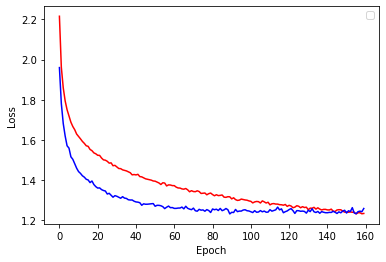

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epoch = range(epochs)
line1 = plt.plot(epoch, train_avg_costs, 'r-')
line2 = plt.plot(epoch, test_avg_costs, 'b-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend([line1, line2], ['train_avg_cost', 'test_avg_cost'])
plt.show()

In [3]:
# 학습된 모델의 성능을 평가하는 코드입니다.
# 아래의 코드로 평가를 진행할 예정이므로 아래의 코드가 정상 동작 해야하며, 제출전 모델의 성능을 확인하시면 됩니다.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose(
      [transforms.ToTensor(),
       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

test_dataset = torchvision.datasets.CIFAR10(root="CIFAR10/",
                                            train=False,
                                            transform=transform,
                                            download=True)


test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=10000)

classifier = Classifier().to(device)
classifier.load_state_dict(torch.load('model.pt'))
classifier.eval()


for data, label in test_dataloader:
    data = data.view(-1, 32 * 32 * 3).to(device)

    with torch.no_grad():
        logits = classifier(data)

        pred = torch.argmax(logits, dim=1)

        total = len(label)
        correct = torch.eq(pred, label.to(device)).sum()

        print("Accuracy on test set : {:.4f}%".format(100 * correct / total))

Files already downloaded and verified


FileNotFoundError: ignored